In [1]:
import sys
from src.consts import IN_COLAB, MAX_PADDING_SLICES, DATASET_MAX_BOUNDING_BOX, DESIRE_BOUNDING_BOX_SIZE

if IN_COLAB:
    print('Found Google Colab')
    !pip3 install torch torchvision torchsummary
    !pip3 install simpleitk

    # noinspection PyUnresolvedReferences
    from google.colab import drive
    drive.mount('/content/drive')

import numpy as np
import matplotlib.pyplot as plt
import torch
import SimpleITK as sitk

import src.helpers.oars_labels_consts as OARS_LABELS

from operator import itemgetter
from IPython.display import display, Markdown
from ipywidgets import widgets
from importlib import reload

from src.training_helpers import loss_batch, show_model_info
from src.helpers.prepare_model import prepare_model
from src.helpers.train_loop import train_loop
from src.helpers.get_dataset import get_dataset, get_dataloaders, get_copy_dataloaders
from src.helpers.get_dataset_info import get_dataset_info
from src.helpers.preview_dataset import preview_dataset
from src.helpers.get_bounding_box import get_bounding_box, get_bounding_box_3D, get_bounding_box_3D_size, get_dividable_bounding_box, get_final_bounding_box_slice
from src.helpers.dataset_cut_helpers import get_full_res_cut

torch.manual_seed(20)

print('Dataset biggest bounding box wihtout spinal cord', DATASET_MAX_BOUNDING_BOX)
print('Cut target size', DESIRE_BOUNDING_BOX_SIZE)
print('Done Init')

Dataset biggest bounding box wihtout spinal cord [56, 177, 156]
Cut target size [72, 192, 168]
Done Init


# Neural Network

## loading low res dataset

In [2]:
filter_labels = OARS_LABELS.OARS_LABELS_LIST
if OARS_LABELS.SPINAL_CORD in filter_labels:
    filter_labels.remove(OARS_LABELS.SPINAL_CORD)

low_res_dataset = get_dataset(dataset_size=50, shrink_factor=16, filter_labels=filter_labels, unify_labels=True)
low_res_dataset.dilatate_labels(repeat=1)
low_res_dataset.to_numpy()
low_res_dataset.show_data_type()
low_res_dataloaders_obj = get_dataloaders(low_res_dataset, train_size=40, valid_size=5, test_size=5)

get_dataset_info(low_res_dataset, low_res_dataloaders_obj)
train_low_res_dataset, valid_low_res_dataset, test_low_res_dataset = itemgetter('train_dataset', 'valid_dataset', 'test_dataset')(low_res_dataloaders_obj)

CUDA using 16x dataset
normalizing dataset
filtering labels
dilatating 1x dataset
parsing dataset to numpy
data type: float64 int8
train 40, valid_size 5, test 5, full 50
train indices [0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 14, 15, 17, 18, 20, 21, 22, 23, 24, 28, 30, 31, 32, 33, 34, 35, 36, 37, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]
valid indices [6, 13, 19, 25, 38]
test indices [16, 26, 27, 29, 39]


In [3]:
preview_dataset(low_res_dataset, preview_index=0, show_hist=False)

data max 12.505709639268096, min -0.40698009878688973
label max 1, min 0


Output()

## training low res model

In [4]:
# preparing model loop params
low_res_model_info = prepare_model(epochs=30, in_channels=8, train_dataset=train_low_res_dataset, valid_dataset=valid_low_res_dataset, test_dataset=test_low_res_dataset)
show_model_info(low_res_model_info)

# getting everything necessary for model training
low_res_train_loop_params = {k:v for k,v in low_res_model_info.items() if k not in ['model_total_params', 'model_total_trainable_params']}
# running training loop
train_loop(**low_res_train_loop_params)

low_res_model = itemgetter('model')(low_res_model_info)

Device running "cuda"
max output channels 128
Model number of params: 1193537, trainable 1193537
Running training loop
Batch eval [1] loss 0.95343, dsc 0.04657
Batch eval [2] loss 0.96482, dsc 0.03518
Batch eval [3] loss 0.96577, dsc 0.03423
Batch eval [4] loss 0.96399, dsc 0.03601
Batch eval [5] loss 0.96245, dsc 0.03755
Epoch [1] T 7.31s, deltaT 7.31s, loss: train 0.96122, valid 0.96209, dsc: train 0.03878, valid 0.03791
Batch eval [1] loss 0.94523, dsc 0.05477
Batch eval [2] loss 0.95422, dsc 0.04578
Batch eval [3] loss 0.94811, dsc 0.05189
Batch eval [4] loss 0.95764, dsc 0.04236
Batch eval [5] loss 0.94574, dsc 0.05426
Epoch [2] T 14.62s, deltaT 7.31s, loss: train 0.95465, valid 0.95019, dsc: train 0.04535, valid 0.04981
Batch eval [1] loss 0.94144, dsc 0.05856
Batch eval [2] loss 0.95083, dsc 0.04917
Batch eval [3] loss 0.94499, dsc 0.05501
Batch eval [4] loss 0.95518, dsc 0.04482
Batch eval [5] loss 0.94210, dsc 0.05790
Epoch [3] T 21.94s, deltaT 7.32s, loss: train 0.95050, vali

## loading high/full res dataset

In [5]:
full_res_dataset = get_dataset(dataset_size=50, shrink_factor=1, filter_labels=filter_labels, unify_labels=False)
full_res_dataset.to_numpy()
full_res_dataset.show_data_type()
print('full dataset RAM sizes in GB', full_res_dataset.get_data_size())

preview_dataset(full_res_dataset, preview_index=0, show_hist=False)

print('dataset data and label shapes', low_res_dataset.data_list[0].shape, full_res_dataset.data_list[0].shape)

CUDA using 1x dataset
normalizing dataset
filtering labels
parsing dataset to numpy
data type: float64 int8
data max 12.81577046544424, min -0.40489707167932215
label max 22, min 0


Output()

dataset data and label shapes (1, 160, 32, 32) (1, 160, 512, 512)


## testing precoarse network


In [6]:
# moving model to cpu and setting to eval mode, preventing model params changes/training
low_res_model.to('cpu')
low_res_model.eval()
print('moved model to cpu')

moved model to cpu


### getting bounding box cut in full res

In [7]:
def get_cut_lists(low_res_model, low_res_dataset, full_res_dataset, cut_full_res_dataset, low_res_mask_threshold=0.5):    
    for i in range(len(full_res_dataset)):
        print(f'getting cut index {i}')
        low_res_data_img = low_res_dataset.data_list[i]
        full_res_data_img = full_res_dataset.data_list[i]
        full_res_label_img = full_res_dataset.label_list[i]

        data_cut, label_cut, new_bounding_box = get_full_res_cut(low_res_model, 
                                                                 low_res_data_img, 
                                                                 full_res_data_img, 
                                                                 full_res_label_img, 
                                                                 low_res_mask_threshold,
                                                                 DESIRE_BOUNDING_BOX_SIZE, 
                                                                 show_debug=False)
        cut_full_res_dataset.data_list[i] = data_cut
        cut_full_res_dataset.label_list[i] = label_cut
        
    return cut_full_res_dataset

In [8]:
full_res_dataloaders_obj = get_copy_dataloaders(full_res_dataset, low_res_dataloaders_obj)
get_dataset_info(full_res_dataset, full_res_dataloaders_obj)

train 40, valid_size 5, test 5, full 50
train indices [0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 14, 15, 17, 18, 20, 21, 22, 23, 24, 28, 30, 31, 32, 33, 34, 35, 36, 37, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]
valid indices [6, 13, 19, 25, 38]
test indices [16, 26, 27, 29, 39]


### debuging cut algorithm

In [9]:
low_res_mask_threshold = 0.5
dataset_index = 42
low_res_data_img = low_res_dataset.data_list[dataset_index]
full_res_data_img = full_res_dataset.data_list[dataset_index]
full_res_label_img = full_res_dataset.label_list[dataset_index]

data_cut, label_cut, new_bounding_box = get_full_res_cut(low_res_model, 
                                                         low_res_data_img,
                                                         full_res_data_img, 
                                                         full_res_label_img, 
                                                         low_res_mask_threshold,
                                                         DESIRE_BOUNDING_BOX_SIZE, 
                                                         show_debug=True)

debug box delta [29 32 24]
debug, does cut and original label contain the same amount of pixels? True 951804 951804
debug bounding box sizes (43, 160, 144) (72, 192, 168)
debug bounding boxes (65, 107, 160, 319, 176, 319) (51, 122, 144, 335, 164, 331)


Output()

Output()

### running cut algorithm, creating cut dataset

In [10]:
cut_full_res_dataset = full_res_dataset.copy(copy_lists=False)
cut_full_res_dataset = get_cut_lists(low_res_model, low_res_dataset, full_res_dataset, cut_full_res_dataset, low_res_mask_threshold=0.5)

getting cut index 0
debug box delta [21 32 24]
debug, does cut and original label contain the same amount of pixels? True 1223526 1223526
getting cut index 1
debug box delta [24 16 -8]
debug, does cut and original label contain the same amount of pixels? True 1326052 1326052
getting cut index 2
debug box delta [ 20   0 -24]
debug, does cut and original label contain the same amount of pixels? True 1890464 1890464
getting cut index 3
debug box delta [17 32  8]
debug, does cut and original label contain the same amount of pixels? True 1560217 1560217
getting cut index 4
debug box delta [22 32 -8]
debug, does cut and original label contain the same amount of pixels? True 1451227 1451227
getting cut index 5
debug box delta [22 32  8]
debug, does cut and original label contain the same amount of pixels? True 1262651 1262651
getting cut index 6
debug box delta [22 48 -8]
debug, does cut and original label contain the same amount of pixels? True 1566938 1566938
getting cut index 7
debug box d

### reviewing full res and cut dataset

In [11]:
cut_full_res_dataset.show_data_type()
print()
print('full res shape', full_res_dataset.data_list[0].shape, full_res_dataset.label_list[0].shape)
print('cut full res shape', cut_full_res_dataset.data_list[0].shape, cut_full_res_dataset.label_list[0].shape)
print()
print('dataset RAM sizes in GB', full_res_dataset.get_data_size() / 1024**3, cut_full_res_dataset.get_data_size() / 1024**3)
print('single item RAM in GB', full_res_dataset.label_list[0].nbytes / 1024**3, full_res_dataset.data_list[0].nbytes / 1024**3)
print()
preview_dataset(cut_full_res_dataset, max_slices=72)

data type: float64 int8

full res shape (1, 160, 512, 512) (160, 512, 512)
cut full res shape (1, 72, 192, 168) (72, 192, 168)

dataset RAM sizes in GB 17.578125 0.9733200073242188
single item RAM in GB 0.0390625 0.3125

data max 11.780218856954171, min -0.42423961281850314
label max 22, min 0


Output()

### preparing cut model

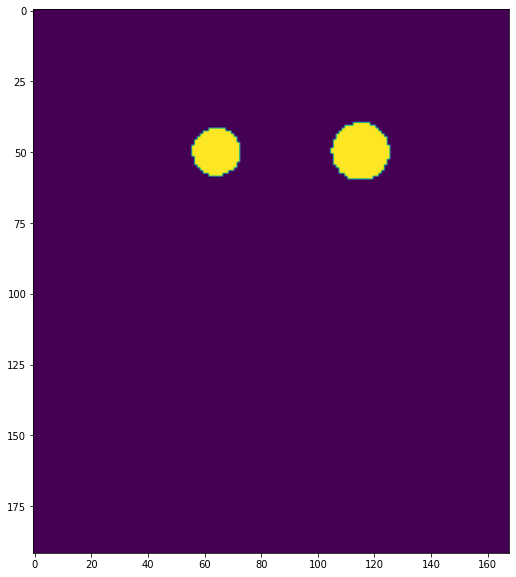

train 40, valid_size 5, test 5, full 50
train indices [0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 14, 15, 17, 18, 20, 21, 22, 23, 24, 28, 30, 31, 32, 33, 34, 35, 36, 37, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]
valid indices [6, 13, 19, 25, 38]
test indices [16, 26, 27, 29, 39]


In [19]:
cut_full_res_dataset.set_output_label([OARS_LABELS.EYE_L, OARS_LABELS.EYE_R, OARS_LABELS.LENS_L, OARS_LABELS.LENS_R])
plt.figure(figsize=(10, 10))
plt.imshow(cut_full_res_dataset.__getitem__(0)[1][47])
plt.show()

cut_dataloaders_obj = get_copy_dataloaders(cut_full_res_dataset, low_res_dataloaders_obj)
get_dataset_info(cut_full_res_dataset, cut_dataloaders_obj)

cut_train_dataset, cut_valid_dataset, cut_test_dataset = itemgetter('train_dataset', 'valid_dataset', 'test_dataset')(cut_dataloaders_obj)

In [22]:
cut_model_info = prepare_model(in_channels=8, train_dataset=cut_train_dataset, valid_dataset=cut_valid_dataset, test_dataset=cut_test_dataset)
show_model_info(cut_model_info)

cut_train_loop_params = {k:v for k,v in cut_model_info.items() if k not in ['model_total_params', 'model_total_trainable_params']}
train_loop(**cut_train_loop_params)

Device running "cuda"
max output channels 128
Model number of params: 1193537, trainable 1193537
Running training loop
Batch eval [1] loss 0.99033, dsc 0.00967
Batch eval [2] loss 0.99231, dsc 0.00769
Batch eval [3] loss 0.98990, dsc 0.01010
Batch eval [4] loss 0.98901, dsc 0.01099
Batch eval [5] loss 0.98318, dsc 0.01682
Epoch [1] T 93.67s, deltaT 93.67s, loss: train 0.98968, valid 0.98895, dsc: train 0.01032, valid 0.01105
Batch eval [1] loss 0.98925, dsc 0.01075
Batch eval [2] loss 0.99120, dsc 0.00880
Batch eval [3] loss 0.98863, dsc 0.01137
Batch eval [4] loss 0.98733, dsc 0.01267
Batch eval [5] loss 0.98083, dsc 0.01917
Epoch [2] T 182.41s, deltaT 88.74s, loss: train 0.98749, valid 0.98745, dsc: train 0.01251, valid 0.01255
Batch eval [1] loss 0.98810, dsc 0.01190
Batch eval [2] loss 0.99014, dsc 0.00986
Batch eval [3] loss 0.98739, dsc 0.01261
Batch eval [4] loss 0.98594, dsc 0.01406
Batch eval [5] loss 0.97887, dsc 0.02113
Epoch [3] T 272.14s, deltaT 89.73s, loss: train 0.98632

160x128x128 = 2_621_440 \
72x198x168 = 2_395_008

## Train Eval

showing number 31
loss 0.12903887033462524, dsc 0.8709611296653748, inputs_len 1


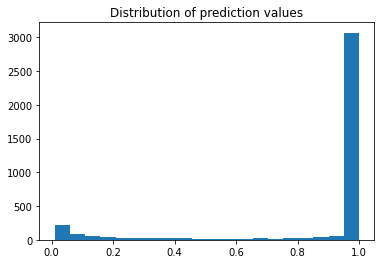

Output()

DEBUG shapes torch.Size([1, 72, 192, 168]) torch.Size([1, 72, 192, 168]) torch.Size([1, 1, 72, 192, 168])
DEBUG prediction max 1.0, min 1.1273865538896644e-06
DEBUG intersection 3227.75830078125
DEBUG label sum 3871.0
DEBUG prediction sum 3541.067138671875
DEBUG intersection2 3227.75830078125
DEBUG dsc 0.8709468245506287
DEBUG MSE 0.00028399520670063794


## Valid Eval

showing number 38
loss 0.10496538877487183, dsc 0.8950346112251282, inputs_len 1


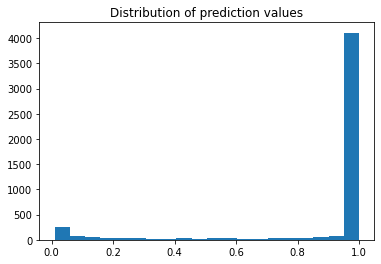

Output()

DEBUG shapes torch.Size([1, 72, 192, 168]) torch.Size([1, 72, 192, 168]) torch.Size([1, 1, 72, 192, 168])
DEBUG prediction max 1.0, min 2.373742745476193e-06
DEBUG intersection 4208.845703125
DEBUG label sum 4761.0
DEBUG prediction sum 4643.89501953125
DEBUG intersection2 4208.845703125
DEBUG dsc 0.895033061504364
DEBUG MSE 0.00029232396627776325


In [41]:
model, device, optimizer, criterion = itemgetter('model', 'device', 'optimizer', 'criterion')(cut_model_info)


def eval_image_dataset(dataset, figfile=None, max_slices=MAX_PADDING_SLICES, default_slice=(MAX_PADDING_SLICES-1)//2):
    with torch.no_grad():
        model.eval()
        torch.cuda.empty_cache()
        print(f'showing number {dataset.indices[0]}')
        inputs, labels = dataset[0]
        inputs = torch.from_numpy(np.array([inputs])).to(device).float()
        labels = torch.from_numpy(np.array([labels])).to(device).float()
        prediction = model(inputs)

        item_loss, item_dsc, inputs_len = loss_batch(model, optimizer, criterion, inputs, labels)
        print(f'loss {item_loss}, dsc {item_dsc}, inputs_len {inputs_len}')

        inputs = inputs.cpu()
        labels = labels.cpu()
        prediction_np = prediction.cpu().detach().numpy()

        plt.hist(prediction_np[prediction_np > 0.01].flatten(), 20)
        plt.title('Distribution of prediction values')
        plt.show()

        def f(slice_index):
            plt.figure(figsize=(30, 16))
            tmp_ax = plt.subplot(1, 3, 1)
            tmp_ax.title.set_text('Input')
            plt.imshow(inputs[0, 0, slice_index], cmap="gray")

            tmp_ax = plt.subplot(1, 3, 2)
            tmp_ax.title.set_text('Label')
            plt.imshow(labels[0, slice_index], cmap="gray")

            tmp_ax = plt.subplot(1, 3, 3)
            tmp_ax.title.set_text('Prediction')
            plt.imshow(prediction_np[0, 0, slice_index], cmap="gray", vmin=0, vmax=1)
            #     plt.subplot(2, 2, 4)
            #     plt.imshow(prediction_np[0, 0, a], cmap="gray")

            if figfile is not None:
                plt.savefig(figfile, dpi=96)
            plt.show()


        aSlider = widgets.IntSlider(min=0, max=max_slices-1, step=1, value=default_slice)
        ui = widgets.VBox([widgets.HBox([aSlider])])
        out = widgets.interactive_output(f, {'slice_index': aSlider })
        display(ui, out)

        print('DEBUG shapes', prediction[:, 0].shape, labels.shape, inputs.shape)
        print(f'DEBUG prediction max {prediction.max().item()}, min {prediction.min().item()}')
        print('DEBUG intersection', (labels.cpu() *  prediction.cpu()[:,0]).sum().item())
        print('DEBUG label sum', labels.cpu().sum().item())
        print('DEBUG prediction sum', prediction.cpu()[:,0].sum().item())

        smooth = 1e-6
        y_pred = prediction.cpu()[:,0].contiguous().view(-1)
        y_true = labels.cpu()[:].contiguous().view(-1)
        intersection = (y_pred * y_true).sum()
        dsc = (2. * intersection + smooth) / (
            y_pred.sum() + y_true.sum() + smooth
        )

        print('DEBUG intersection2', intersection.item())
        print('DEBUG dsc', dsc.item())
        print('DEBUG MSE', (labels.cpu() - prediction.cpu()[:,0]).pow(2).mean().item())


# noinspection PyTypeChecker
display(Markdown("## Train Eval"))
eval_image_dataset(cut_train_dataset, max_slices=cut_train_dataset.__getitem__(0)[1].shape[0], default_slice=49)
# noinspection PyTypeChecker
display(Markdown("## Valid Eval"))
eval_image_dataset(cut_valid_dataset, max_slices=cut_valid_dataset.__getitem__(0)[1].shape[0], default_slice=53)
# display(Markdown("## Test Eval"))
# eval_image_dataset(test_dataset, 78, 'test_plot.png')

72